In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import pandas as pd
from shapely.geometry import Polygon


import pyresample as pr
area_def_north_ease = pr.parse_area_file('C:/Users/emilt/Documents/Noter/N5_ESMR/data/Ressources/areas_ease_v2atle_25km.cfg', 'ease_nh')[0]
lonss, latss = area_def_north_ease.get_lonlats()

import cartopy.crs as ccrs
import cartopy.feature as cfeature


import xarray as xr
import os
from glob import glob
from tqdm import tqdm

import sys
sys.path.append('C:/Users/emilt/Documents/Noter/N5_ESMR/ExperimentalScripts/Functions/')
import Functions as n5 
flagVals = np.array([0,1,2,4,8,16,32,128])

In [2]:
def densify_polygon(geometry, factor=5):
    """Increase the number of points in a polygon by interpolating between existing points."""
    import numpy as np
    
    def interpolate_line(line, num=5):
        coords = list(line.coords)
        new_coords = []
        for i in range(len(coords) - 1):
            start, end = coords[i], coords[i + 1]
            new_coords.append(start)
            for j in range(1, num):
                frac = j / num
                new_coords.append((
                    start[0] + frac * (end[0] - start[0]),
                    start[1] + frac * (end[1] - start[1])
                ))
        new_coords.append(coords[-1])
        return new_coords

    if geometry.geom_type == 'Polygon':
        exterior = interpolate_line(geometry.exterior, num=factor)
        interiors = [interpolate_line(ring, num=factor) for ring in geometry.interiors]
        return Polygon(exterior, interiors)
    return geometry  # Handle other cases if needed

# Load Data

In [3]:
dir = 'D:/N5ESMR/N5ESMR_out/ESACCI-SEAICE-L3C-SICONC-NIMBUS5_ESMR-EASE2_NH-fv1.1'
dirlist = glob(os.path.join(dir,'ESACCI-SEAICE-L3C-SICONC-NIMBUS5_ESMR-EASE2_NH-*fv1.1.nc'))

dates = np.arange('1973-01-01', '1973-03-01', dtype='datetime64[D]').astype(object)

files = []
for date in tqdm(dates):
    file = os.path.join(dir, 'ESACCI-SEAICE-L3C-SICONC-NIMBUS5_ESMR-EASE2_NH-'+ '{:04}'.format(date.year)+'{:02}'.format(date.month)+'{:02}'.format(date.day) +'-fv1.1.nc')
    if file in dirlist:
        files.append(file)

ds = xr.merge(xr.open_dataset(f) for f in files)
ds

100%|██████████| 59/59 [00:00<?, ?it/s]


<xarray.Dataset>
Dimensions:                   (time: 59, xc: 432, yc: 432, nv: 2)
Coordinates:
  * time                      (time) datetime64[ns] 1973-01-01T12:00:00 ... 1...
  * xc                        (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                        (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                       (yc, xc) float32 16.62 16.82 17.02 ... 16.82 16.62
    lon                       (yc, xc) float32 -135.0 -135.1 ... 44.87 45.0
Dimensions without coordinates: nv
Data variables:
    raw_ice_conc_values       (time, yc, xc) float32 nan nan nan ... nan nan nan
    algorithm_standard_error  (time, yc, xc) float32 nan nan nan ... nan nan nan
    Tb_corr                   (time, yc, xc) float32 nan nan nan ... nan nan nan
    Tb                        (time, yc, xc) float32 nan nan nan ... nan nan nan
    smearing_standard_error   (time, yc, xc) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    total_standard_error      (time, yc, xc) float32 nan nan nan ... nan nan nan
    status_flag               (time, yc, xc) float64 64.0 64.0 64.0 ... 1.0 1.0
    ice_conc                  (time, yc, xc) float32 0.0 0.0 0.0 ... nan nan nan
    Lambert_Azimuthal_Grid    int32 -2147483647
    time_bnds                 (time, nv) datetime64[ns] 1973-01-01 ... 1973-0...
Attributes: (12/39)
    description:               Weather related data.
    title:                     Sea Ice Concentration Climate Data Record from...
    summary:                   This climate data record of sea ice concentrat...
    opiccategory:              Oceans Climatology Meteorology Atmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    ...                        ...
    contributor_role:          PrincipalInvestigator, Co-Investigator, Co-Inv...
    product_version:           1.1
    tracking_id:               c89d8e39-1577-46ba-89ab-68e90d12635e
    naming_authority:          esa.int
    Conventions:               CF-1.6 ACDD-1.3
    standard_name_vocabulary:  Using Standard Name Table Version 78 (2021-09-...

# Define Masks

In [5]:

MYI = Polygon(((80,-170),(80,-105),(84,-105),(84,-17),(88,-17),(88,-170)))
FYI1 = Polygon(((140,240),(155,240),(155,255),(140,255)))
FYI2 = Polygon(((75,215),(155,240),(155,255),(140,255)))


In [6]:
def MYI_Mask(lat,lon):
    mask = np.ones(lat.shape).astype(bool)
    mask[lat>88]=False
    mask[lat<80]=False
    mask[lon>-17]=False
    mask[lon<-170]=False
    mask[(lat<84) & (lon>-105)]=False

    return mask
MYImask= MYI_Mask(latss,lonss)

def FYI_Mask(lat,lon):
    mask1 = np.zeros(lat.shape).astype(bool)
    mask2 = np.zeros(lat.shape).astype(bool)
    mask3 = np.zeros(lat.shape).astype(bool)
    mask1[240:255,140:155] = True
    mask2[215:240,75:90] = True
    mask3[219:234,259:275]= True
    return (mask1 | mask2 | mask3)
FYImask = FYI_Mask(latss,lonss)

C:\Users\emilt\AppData\Local\Temp\ipykernel_28340\602402993.py:4: RuntimeWarning: Mean of empty slice
  Tbmean = np.nanmean(ds['Tb_corr'].to_numpy(),axis=0)


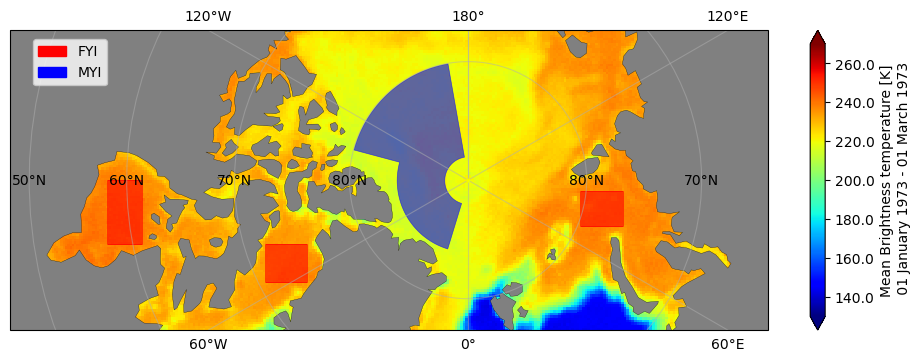

In [7]:
labels = ['FYI','MYI']
colors = ['red','blue']

Tbmean = np.nanmean(ds['Tb_corr'].to_numpy(),axis=0)

Masks = np.ones(latss.shape)*np.nan
Masks[FYImask]=0
Masks[MYImask]=1
MYI = Polygon(((-170,80),(-105,80),(-105,84),(-17,84),(-17,88),(-170,88)))
FYI1 = Polygon(((-3370000,0),(-3050000,0),(-3050000,-600000),(-3370000,-600000)))
FYI2 = Polygon(((-1900000,-600000),(-1500000,-600000),(-1500000,-950000),(-1900000,-950000)))
FYI3 = Polygon(((1450000,-100000),(1050000,-100000),(1050000,-430000),(1450000,-430000)))

proj = ccrs.Orthographic(0, 90)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='none',
                                        facecolor=np.array([0.5,0.5,0.5]))
fig, ax = plt.subplots(1,1,figsize=(10,3.5), subplot_kw={'projection': proj},layout='constrained')
ax.set_facecolor('gray')
im=ax.pcolormesh(lonss,latss,Tbmean,vmin=130,vmax=270,cmap='jet', transform = ccrs.PlateCarree())
#im=ax.pcolormesh(lonss,latss,Masks, transform = ccrs.PlateCarree(),cmap='spring')
#ax.coastlines()
ax.add_feature(land)
ax.add_geometries(densify_polygon(FYI1,50),crs=proj,zorder=1,color=colors[0], alpha=0.6, linewidth=0.5)
ax.add_geometries(densify_polygon(FYI2,50),crs=proj,zorder=1,color=colors[0], alpha=0.6, linewidth=0.5)
ax.add_geometries(densify_polygon(FYI3,50),crs=proj,zorder=1,color=colors[0], alpha=0.6, linewidth=0.5)
ax.add_geometries(densify_polygon(MYI,50),crs=ccrs.PlateCarree(),zorder=1,color=colors[1], alpha=0.6, linewidth=0.5)
ax.set_extent((-5000000, 3000000, -1500000, 1500000), crs=ccrs.NorthPolarStereo())
ax.gridlines(alpha=0.5,draw_labels=True, dms=True, x_inline=False, y_inline=True)

patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(0,2) ]
ax.coastlines(resolution='110m', color='black', linewidth=0.2)

fig.colorbar(im,label='Mean Brightness temperature [K]\n 01 January 1973 - 01 March 1973',extend='both',format='%.1f')
plt.legend(handles=patches, bbox_to_anchor=(0.03, 0.97), loc=2, borderaxespad=0. )
plt.savefig('ReferenceAreas.png', bbox_inches='tight',dpi=300)

# Calibration analysis

In [8]:
class TimeSeriesAnalyzer:
    def __init__(self, Tb, mask):
        self.data = Tb.to_numpy()[:,mask]
        self.ndays = self.data.shape[0]
        self.nsamples = self.data.shape[1]

    def calc_rstd(self, periodLength):
        rStd = np.empty(self.data.shape)
        pd = periodLength//2

        for t in range(self.ndays):
            if t<pd or t>self.ndays-pd-1:
                rStd[t,:] = np.nan
            else:
                for id in range(self.nsamples):
                    data2use = self.data[t-pd:t+pd+1,id]
                    rStd[t,id] = np.std(data2use)
        return rStd
    
    def summarize(self, periodLength,thresh):
        rStd = self.calc_rstd(periodLength)
        stats = {'periodLength': periodLength,
                'mean': np.nanmean(np.nanmean(rStd, axis=0)), 
                 'std': np.nanmean(np.nanstd(rStd, axis=0)),
                 'min': np.nanmean(np.nanmin(rStd, axis=0)),
                 'max': np.nanmean(np.nanmax(rStd, axis=0)),
                 'median': np.nanmean(np.nanmedian(rStd, axis=0)),
                 'numobs': np.sum(~np.isnan(rStd))/self.nsamples,
                 'percentile 2.5%': np.nanmean(np.nanpercentile(rStd, 2.5, axis=0)),
                 'percentile 97.5%': np.nanmean(np.nanpercentile(rStd, 97.5, axis=0)),
                 'q1': np.nanmean(np.nanpercentile(rStd, 25, axis=0)),
                 'q3': np.nanmean(np.nanpercentile(rStd, 75, axis=0)),
                 'obsBelowThresh': np.nanmean(np.sum(rStd<thresh)/self.nsamples)}
        return stats
    
    def summarize_all_periodLengths(self, periods,thresh):
        summary = []
        for periodLength in tqdm(periods):
            summary.append(self.summarize(periodLength,thresh))
        return pd.DataFrame(summary)
    

In [9]:
def boxPlotter(ax, df, title, ylabel, xticks, ylim):
    width = 0.2

    # Sample data: statistics for 5 data series
    datastats = []
    for idx in df.index:
        datastats.append({'mean': df['mean'][idx], 'median': df['median'][idx], 'min': df['min'][idx], 'max': df['max'][idx], 'q1': df['q1'][idx], 'q3': df['q3'][idx]})

    # Positions of boxplots
    positions = range(1, len(datastats) + 1)

    # Create boxplots manually
    for i, stats in enumerate(datastats):
        # Box
        ax.plot([positions[i]-width, positions[i]+width], [stats['q1'], stats['q1']],color='gray', lw=1)
        ax.plot([positions[i]-width, positions[i]+width], [stats['q3'], stats['q3']],color='gray', lw=1)
        ax.plot([positions[i]-width, positions[i]-width], [stats['q1'], stats['q3']],color='gray', lw=1)
        ax.plot([positions[i]+width, positions[i]+width], [stats['q1'], stats['q3']],color='gray', lw=1)
        
        # Whiskers
        ax.plot([positions[i], positions[i]], [stats['min'], stats['q1']], color='gray', lw=1)
        ax.plot([positions[i], positions[i]], [stats['q3'], stats['max']], color='gray', lw=1)
        
        # Min/Max (whisker ends)
        ax.plot([positions[i] - width, positions[i] + width], [stats['min'], stats['min']], color='gray')
        ax.plot([positions[i] - width, positions[i] + width], [stats['max'], stats['max']], color='gray')
        
        # Median
        ax.plot([positions[i] - width, positions[i] + width], [stats['median'], stats['median']], color='red', lw=2)
    ax.plot(positions, df['median'],'r--',lw=1,label='rStd')

    # Customizing plot
    ax.set_xticks(positions)
    ax.set_xticklabels(xticks)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.grid(alpha=0.3)
    ax.set_ylim(ylim)
    ax.set_title(title)

In [10]:
periods = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]

Tb = ds['Tb_corr']
MYImask =  MYI_Mask(latss,lonss)
FYImask =  FYI_Mask(latss,lonss)
ALLmask = MYImask | FYImask

In [ ]:
TSA_fyi = TimeSeriesAnalyzer(Tb, FYImask)
summary_FYI = TSA_fyi.summarize_all_periodLengths(periods,thresh=3.737)

TSA_myi = TimeSeriesAnalyzer(Tb, MYImask)
summary_MYI = TSA_myi.summarize_all_periodLengths(periods,thresh=3.737)

TSA_all = TimeSeriesAnalyzer(Tb, ALLmask)
summary_ALL = TSA_all.summarize_all_periodLengths(periods,thresh=3.737)

 60%|██████    | 9/15 [00:05<00:03,  1.71it/s]C:\Users\emilt\AppData\Local\Temp\ipykernel_23532\2631358923.py:23: RuntimeWarning: Mean of empty slice
  'mean': np.nanmean(np.nanmean(rStd, axis=0)),
c:\Users\emilt\anaconda3\envs\N5ESMR\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\emilt\AppData\Local\Temp\ipykernel_23532\2631358923.py:25: RuntimeWarning: All-NaN slice encountered
  'min': np.nanmean(np.nanmin(rStd, axis=0)),
C:\Users\emilt\AppData\Local\Temp\ipykernel_23532\2631358923.py:26: RuntimeWarning: All-NaN slice encountered
  'max': np.nanmean(np.nanmax(rStd, axis=0)),
C:\Users\emilt\AppData\Local\Temp\ipykernel_23532\2631358923.py:27: RuntimeWarning: All-NaN slice encountered
  'median': np.nanmean(np.nanmedian(rStd, axis=0)),
c:\Users\emilt\anaconda3\envs\N5ESMR\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered

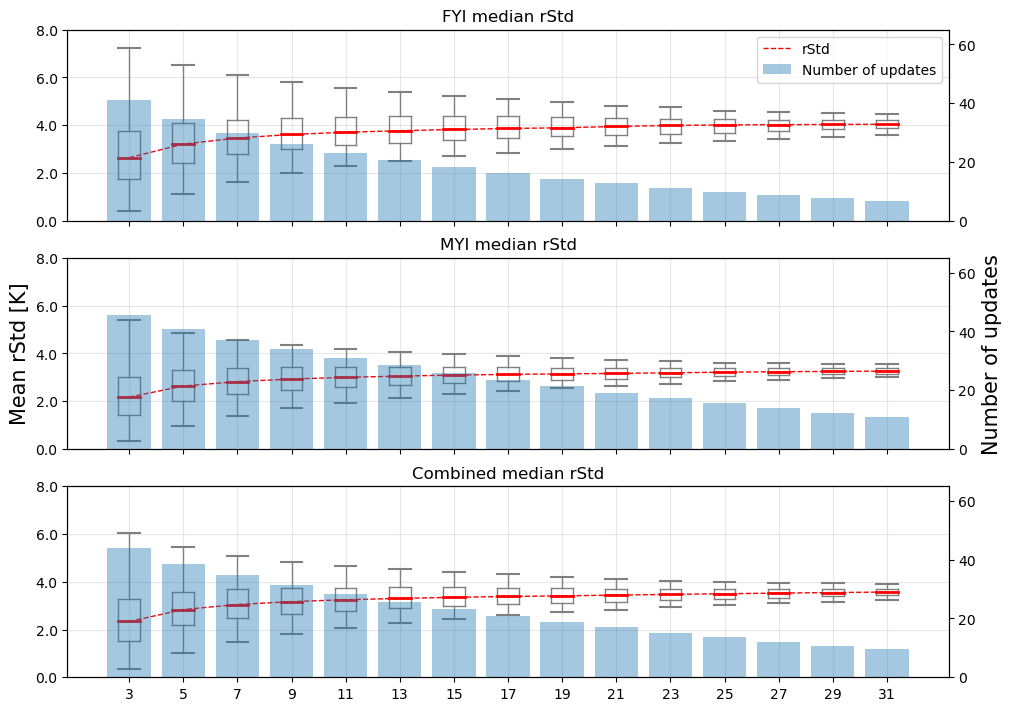

In [ ]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(10,7),layout='constrained')


ax1 = ax[0]
ax2 = ax1.twinx()
boxPlotter(ax1, summary_FYI, 'FYI median rStd', '', periods, [0, 8])
ax2.bar(range(1,len(summary_FYI['periodLength'])+1),summary_FYI['obsBelowThresh'],alpha=0.4,label='Number of updates')
ax2.set_ylim([0,65])
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)

ax1 = ax[1]
ax2 = ax1.twinx()
boxPlotter(ax1, summary_MYI, 'MYI median rStd', 'Mean rStd [K]', periods, [0, 8])
ax2.bar(range(1,len(summary_MYI['periodLength'])+1),summary_MYI['obsBelowThresh'],alpha=0.4,label='Number of updates')
ax2.set_ylabel('Number of updates',fontsize=15)
ax2.set_ylim([0,65])

ax1 = ax[2]
ax2 = ax1.twinx()
boxPlotter(ax1, summary_ALL, 'Combined median rStd', '', periods, [0, 8])
ax2.bar(range(1,len(summary_ALL['periodLength'])+1),summary_ALL['obsBelowThresh'],alpha=0.4,label='Number of updates')
ax2.set_ylim([0,65])

plt.savefig('rStd_histograms.pdf', bbox_inches='tight')
#plt.show()

# TimeFlow

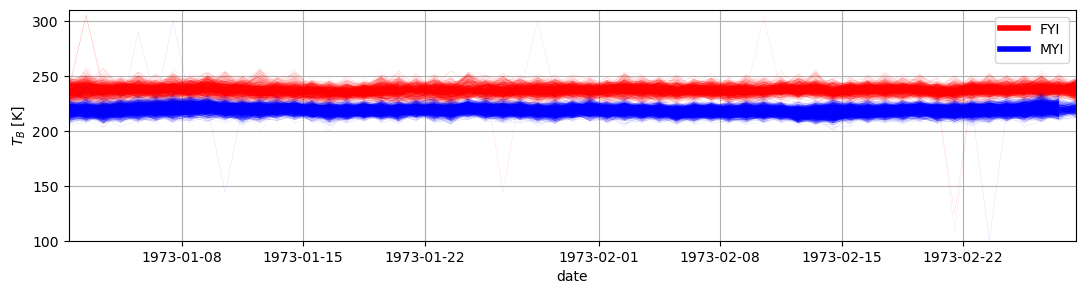

In [11]:
from matplotlib.lines import Line2D

Tb = ds['Tb_corr']
MYImask =  MYI_Mask(latss,lonss)
FYImask =  FYI_Mask(latss,lonss)

Tb_fyi = Tb.to_numpy()[:,FYImask]
Tb_myi = Tb.to_numpy()[:,MYImask]
time = ds['time'].to_numpy()

plt.figure(figsize=(13,3))
plt.plot(time,Tb_fyi,'r-',linewidth=0.2,alpha=0.2)
plt.plot(time,Tb_myi,'b-',linewidth=0.2,alpha=0.2)
plt.xlabel('date')
plt.ylabel('$T_B$ [K]')
plt.grid()

custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4)]

plt.legend(custom_lines,['FYI','MYI'])
plt.xlim([time[0],time[-1]])
plt.ylim([100,310])
plt.show()

In [12]:
np.sum(Tb_fyi>255)

19